# Feature selection

In case statistical significance of the impact of the regressors is in question, or  multicollinearity or overfitting is observed, reducing complexity of the model (number of features or their dimensionality) is usually recommended. The most straighforward way of doing so is through feature selection. 

This can be done by selecting a subset of the regressors of the given size $k$ maximizing the model fit ($R^2$) over the validation sample. Two common ways of doing that are
- Step-backward: keep removing regressors (one by one) having the highest negative or lowest positive impact on the validation $R^2$, until a target number of features is reached or until validation $R^2$ can not be improved anymore;
- Step-forward: keep adding regressors (one by one) having the maximal positive impact or minimal negative impact on the validation $R^2$, until a target number of features is reached or until validation $R^2$ can not be improved anymore.

Those are not the only two ways - one can also consider more sophisticated heursitics for the selection of the best combination of the regressors. 

Drawback - by removing regressors we're discarding information from the feature space, while it could happen that both - noise as well as important information - are spread among all the regressors.

### An artificial example to demonstrate feature selection based on maximizing validation $R^2$, adjusted R2 and selecting features by p-values

The regular $R^2$:
$$
R^2=1-\frac{RSS}{\sum_i (y_i-\bar{y})^2}=\frac{\sum_i (\hat{y}_i-\bar{y})^2}{\sum_i (y_i-\bar{y})^2},
$$
The adjusted $R^2$ (adjusts the model performance metric by the model complexity (number of features used)):
$$
adj.R^2=1-\frac{RSS}{\sum_i (y_i-\bar{y})^2} \cdot \frac{N-1}{N-P-1} 
$$
where $N$ is the total sample size and $P$ is the number of features/selected variables

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline
import statsmodels.formula.api as smf
from scipy.stats import t
from sklearn.metrics import r2_score
matplotlib.rcParams['figure.figsize'] = [10,4]

Populating the interactive namespace from numpy and matplotlib


In [2]:
#generate the data
n = 15
np.random.seed(2)

col = []
for i in range(n):
    col.append('x%d'%(i+1))

X = pd.DataFrame(np.random.randn(50*n).reshape(50,n))
Y = X.iloc[:,[3,5,7]].sum(axis = 1) + 0.7*np.random.randn(50) #Y = x4+x6+x8+N(0,0.7)
data3 = pd.concat((Y,X), axis = 1)  # concatenate Y and X
data3.columns = ['Y'] + col         # rename the columns
train = data3[:20]
valid = data3[20:]

In [3]:
train.head()

,Y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15
0,-0.439741,-0.416758,-0.056267,-2.136196,1.640271,-1.793436,-0.841747,0.502881,-1.245288,-1.057952,-0.909008,0.551454,2.292208,0.041539,-1.117925,0.539058
1,-1.034245,-0.596160,-0.019130,1.175001,-0.747871,0.009025,-0.878108,-0.156434,0.256570,-0.988779,-0.338822,-0.236184,-0.637655,-1.187612,-1.421217,-0.153495
2,0.571933,-0.269057,2.231367,-2.434768,0.112727,0.370445,1.359634,0.501857,-0.844214,0.000010,0.542353,-0.313508,0.771012,-1.868091,1.731185,1.467678
3,-1.108995,-0.335677,0.611341,0.047971,-0.829135,0.087710,1.000366,-0.381093,-0.375669,-0.074471,0.433496,1.278379,-0.634679,0.508396,0.216116,-1.858612
4,-2.000563,-0.419316,-0.132329,-0.039570,0.326003,-2.040323,0.046256,-0.677676,-1.439439,0.524296,0.735280,-0.653250,0.842456,-0.381516,0.066489,-1.098739


In [4]:
#first fit the regression over the training data and report the results
lm = smf.ols(formula = 'Y ~ '+ '+'.join(train.columns[1:]), data = train).fit()
OLS_coef=lm.params
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     18.70
Date:                Tue, 19 Oct 2021   Prob (F-statistic):            0.00593
Time:                        14:47:28   Log-Likelihood:               -0.56537
No. Observations:                  20   AIC:                             33.13
Df Residuals:                       4   BIC:                             49.06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2613      0.204      1.282      0.2

In [5]:
#however the out-of-sample validation R2 does not look good; overfitting detected
r2_score(valid.Y,lm.predict(valid))

-0.22206015314306682

In [6]:
# The auxiliary function implementing regression based on the selected subset of features
def AdjR2(flag):
    '''
    Evalute the model with adjusted R-squared,
    with flag indicating the feature selection
    1--feature included
    0--feature excluded
    '''
    formstr='Y~-1'
    for i in range(len(flag)):
        if flag[i]==1:
            formstr += '+x%d'%(i+1) # Construct the regression formula based on flag
    lm = smf.ols(formula = formstr, data = train).fit()
    lmy = lm.predict(valid)
    y_err = lmy-valid.Y
    y_norm = valid.Y-mean(valid.Y)
    # Adjusted R^2
    R2_OS = 1 - y_err.dot(y_err) / y_norm.dot(y_norm)
    adjR2_OS = 1 - y_err.dot(y_err) / y_norm.dot(y_norm) * (n-1) / (n-sum(flag)-1)
    return lm, R2_OS, adjR2_OS

### Revisit the overfitting:

In [7]:
#implement the regression with out-of-sample evaluation for different numbers of features included 
adjR2 = []
regR2 = []
OSR2 = []
for i in range(1, n):
    lm, R2_OS, adjR2_OS = AdjR2([1]*i + [0]*(n-i))
    regR2.append(lm.rsquared)
    adjR2.append(lm.rsquared_adj)
    OSR2.append(adjR2_OS)

/var/folders/qb/17l1h3xd089d25ckc1rphr9w0000gn/T/ipykernel_4416/2439123399.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  adjR2_OS = 1 - y_err.dot(y_err) / y_norm.dot(y_norm) * (n-1) / (n-sum(flag)-1)


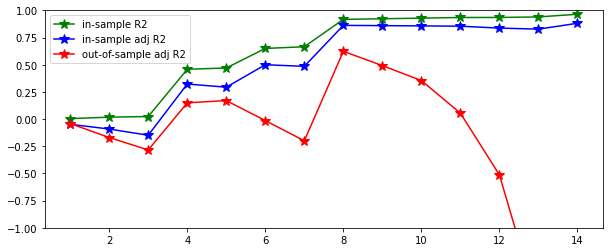

In [8]:
# In sample R2
plt.plot(range(1, n), regR2, 'g-*', markersize = 10)
plt.plot(range(1, n), adjR2, 'b-*', markersize = 10)
plt.plot(range(1, n), OSR2, 'r-*', markersize = 10)
plt.ylim((-1,1))
plt.legend(('in-sample R2','in-sample adj R2','out-of-sample adj R2'))

### Alternative (not generally recommended) approach based on features' statistical significance
As the regression reports p-values which can be used in order to understand the statistical significance of the features' impact, one may think of using it to perform feature selection (keep only the features with statistically signifiance impact, i.e. low p-value). Unfortunately this does not always work well as multicollinearity often mixes up the impacts of different features and the ones that actually matter may apparently have high p-value and will get excluded by this approach.

First, we can take a look at the regression above including all features and observe their p-values. 

Then keep only the features having p-value below 5\%

In [9]:
# Feature selection based on the p-values
def DropP(threshold = 1):
    '''Drop all features with p-values higher than the threshold'''
    flag_p = (AdjR2([1]*n)[0]).pvalues < threshold
    print(AdjR2(flag_p)[0].summary())
    print('Validation R2/adjusted ^2=%f/%f'%AdjR2(flag_p)[1:3])

In [10]:
DropP(0.05) #we can see that not the 

                                 OLS Regression Results                                
Dep. Variable:                      Y   R-squared (uncentered):                   0.573
Model:                            OLS   Adj. R-squared (uncentered):              0.526
Method:                 Least Squares   F-statistic:                              12.10
Date:                Tue, 19 Oct 2021   Prob (F-statistic):                    0.000468
Time:                        14:47:33   Log-Likelihood:                         -34.745
No. Observations:                  20   AIC:                                      73.49
Df Residuals:                      18   BIC:                                      75.48
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Next we try to select a feature maximizing validation adjusted $R^2$

In [11]:
# Find the best feature selection (forward step-wise) that maximizes the out-of-sample adjusted R2
def FindBestI():
    flag = np.zeros(n)    # initially exclude all regressors: 1-include, 0-exclude
    r2max = 0             # for storing and compare with best R^2
    while True:
        flag_mat = np.maximum(np.eye(n),flag) #create the matrix with rows representing the cases of adding each new feature
        # see if R2 increases if we add one more feature
        r2 = np.apply_along_axis(AdjR2,1,flag_mat)[:,1]  # 1: row-wise operation producing the validation R2 for each row (combination of features)
        temp = r2.max() #take the best R2
        if temp > r2max:
            r2max = temp
            flag = flag_mat[r2.argmax()]  # select the feature set that improved R2
        else:
            break                         # if there's nothing to add, break the loop
    return flag

flag = FindBestI()             # store the best choice of feature selection
lm_best,_,r2_best = AdjR2(flag)  # then run the regression based on such selection
ix = [col[i] for i in range(n) if flag[i]==1]

b = pd.DataFrame({'Pvalues':AdjR2([1]*n)[0].pvalues, 'Keep':col})
c = 'forestgreen'
def highlight_pval(val):
    color = c if val in ix else 'white'
    return 'background-color: %s'%color

b.style.applymap(highlight_pval, subset=['Keep']).\
    bar(subset = ['Pvalues'], color=c)

,Pvalues,Keep
x1,0.467199,x1
x2,0.811237,x2
x3,0.778028,x3
x4,0.004776,x4
x5,0.663017,x5
x6,0.318358,x6
x7,0.072874,x7
x8,0.122756,x8
x9,0.739355,x9
x10,0.038170,x10


The length of green bar in right column indicates the p-value, and we can see that despite having high p-value,  $x_6$ and $x_8$ are still included after feature selection, which is consistent with our true model $y \sim x_4 + x_6 + x_8$

In [12]:
print('Validation R^2 is %f'%r2_best)
print(lm_best.summary())

Validation R^2 is 0.739678
                                 OLS Regression Results                                
Dep. Variable:                      Y   R-squared (uncentered):                   0.906
Model:                            OLS   Adj. R-squared (uncentered):              0.843
Method:                 Least Squares   F-statistic:                              14.38
Date:                Tue, 19 Oct 2021   Prob (F-statistic):                    4.64e-05
Time:                        14:47:36   Log-Likelihood:                         -19.669
No. Observations:                  20   AIC:                                      55.34
Df Residuals:                      12   BIC:                                      63.30
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------

and now once many of the irrelecant features got excluded, reducing the degree of multicollinearity, p-values already appear to be indicative to the features having significant impact - only $x_4,x_6,x_8$ have p-values below 5%. And as we can recall those were the features used to construct the model generating the data

In [13]:
#if we keep just those, the R2 does not drop much and adjusted R2 even increase
lm_best2 = smf.ols(formula = 'Y ~ x4 + x6 + x8', data = train).fit()
print(lm_best2.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     42.23
Date:                Tue, 19 Oct 2021   Prob (F-statistic):           7.91e-08
Time:                        14:47:36   Log-Likelihood:                -21.329
No. Observations:                  20   AIC:                             50.66
Df Residuals:                      16   BIC:                             54.64
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0949      0.188     -0.505      0.6

In [14]:
#out-of-sample validation R2 looks quite good now, higher than before and now pretty close to in-sample; 
#so sometimes feature selection based on p-values can work well, but only if multicollinearity is not too severe
r2_score(valid.Y,lm_best2.predict(valid))

0.8677268761018012